# Importation des librairies :

In [ ]:
pip install astral

In [ ]:
pip install lightgbm

In [ ]:
pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import tensorflow as tf
import lightgbm as lgb
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from astral.sun import sun
from astral import LocationInfo

# Configurer les jours fériés en Turquie
tur_holidays = holidays.Turkey()

# Désactiver les avertissements
warnings.filterwarnings('ignore')

# Importation des données :

In [ ]:
#importation de la data
df = pd.read_csv('/content/full_data.csv')

# Preprocessing et Feature engineering :

Nous avons transformé l'heure, les jours de la semaine et le jour du mois, en représentations cycliques utilisant les fonctions trigonométriques sinus et cosinus.

Les variables créées comprennent 'sin_hour' et 'cos_hour' pour représenter l'heure du jour sur un cycle de 24 heures, 'sin_day_of_week' et 'cos_day_of_week' pour représenter le jour de la semaine sur un cycle de 7 jours, et enfin 'sin_day_of_month' et 'cos_day_of_month' pour représenter le jour du mois sur un cycle de 30 jours approximatif.

Ces variables cycliques sont utiles dans les modèles de prévision car elles permettent de prendre en compte la périodicité des données temporelles de manière continue, évitant ainsi les discontinuités. Elles améliorent la capacité des modèles à identifier et à généraliser les schémas temporels, ce qui est crucial pour une précision accrue dans les prévisions de consommation d'énergie.

In [ ]:
df['time'] = pd.to_datetime(df['time'], format='%d:%m:%Y:%H:%M')

# Extraire les heures, jours de la semaine et jours du mois
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_month'] = df['time'].dt.day

# Heure (cycle de 24 heures)
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Jour de la semaine (cycle de 7 jours)
df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Jour du mois (cycle de 30 jours approximatif)
df['sin_day_of_month'] = np.sin(2 * np.pi * df['day_of_month'] / 30)
df['cos_day_of_month'] = np.cos(2 * np.pi * df['day_of_month'] / 30)

In [ ]:
# Solar négatif : pour toute valeur négative on la remplace par zero
df['solar'] = df['solar'].clip(lower=0)

 Par la suite , nous avons regroupé les différentes sources d'énergie, puis calculé les totaux pour chaque groupe et évaluer les parts des énergies renouvelables et non renouvelables dans le mix énergétique global. Cela offre une vue d'ensemble utile pour analyser la composition et la répartition de la production d'énergie.

In [ ]:
# Définition des groupes d'énergie
energy_groups = {
    'fossil_fuel_MWh': ['natural_gas', 'lignite', 'coal_imported', 'fuel_oil', 'asphaltite_coal', 'hard_coal', 'naphtha'],
    'renewable_energy_MWh': ['hydro_dam', 'hydro_river', 'wind', 'solar', 'geothermal', 'biomass'],
    'alternative_energy_MWh': ['LNG', 'international', 'waste_heat']
}

# Calcul des totaux pour chaque groupe d'énergie
for new_col, columns in energy_groups.items():
    df[new_col] = df[columns].sum(axis=1)

# Calcul du total de l'énergie et des parts des énergies renouvelables et non-renouvelables
df['Total_energy_MWh'] = df[list(energy_groups.keys())].sum(axis=1)
df['Part_renewable'] = df['renewable_energy_MWh'] / df['Total_energy_MWh']
df['Part_no_renewable'] = df['fossil_fuel_MWh'] / df['Total_energy_MWh']

Nous avons crées de nouvelles variables que nous trouvions intéréssantes pour notre étude :

- Déficit d'énergie : Une nouvelle colonne appelée "deficit_MWh" est créée pour calculer la différence entre la consommation d'énergie ("consumption_MWh") et la production totale d'énergie ("total_generation_MWh"). Cela permet de quantifier l'écart entre la demande et l'offre d'énergie à chaque instant.

- Pourcentage de changement du prix en USD/MWh : La colonne "USD/MWh" est ajustée pour remplacer les valeurs nulles par une petite valeur proche de zéro (1e-10) afin d'éviter les erreurs de division par zéro. Ensuite, le pourcentage de changement du prix en USD/MWh est calculé à partir de la colonne "USD/MWh" en utilisant la méthode pct_change(). Les valeurs manquantes sont remplacées en utilisant la méthode 'bfill' qui propage la dernière valeur valide vers l'avant.

- La moyenne mensuelle de la consommation d'énergie : Le DataFrame est groupé par mois, puis la moyenne mensuelle de la consommation d'énergie est calculée pour chaque groupe. La moyenne mensuelle est ensuite diffusée à l'ensemble des lignes correspondant à chaque mois.

- L'écart type mensuel de la consommation d'énergie : De manière similaire, le DataFrame est groupé par mois et l'écart type mensuel de la consommation d'énergie est calculé pour chaque groupe. Cela permet de quantifier la dispersion des valeurs de consommation d'énergie autour de la moyenne mensuelle pour chaque mois.

In [ ]:
# Déficit :
df["deficit_MWh"] = df["consumption_MWh"] - df["total_generation_MWh"]

# Pourcentage de changement du prix en USD/MWh
df['USD/MWh'] = df['USD/MWh'].replace(0, 1e-10)
df['USD/MWh_rate'] = df['USD/MWh'].pct_change() * 100
df['USD/MWh_rate'].fillna(method='bfill', inplace=True)

# Calcul la moyenne mensuelle de la consommation
df['consumption_MWh_mean_month'] = df.groupby(df['time'].dt.to_period('M'))['consumption_MWh'].transform('mean')

# Calcul d'écart type mensuel de la consommation
df['consumption_MWh_std_month'] = df.groupby(df['time'].dt.to_period('M'))['consumption_MWh'].transform('std')

Le seuil de période de pointe est défini comme la valeur correspondant au 95e percentile de la consommation d'énergie, où 95% des observations sont inférieures ou égales à ce seuil. En créant l'indicateur "peak_period_indicator", les périodes de pointe sont identifiées lorsque la consommation d'énergie dépasse ou égale ce seuil, facilitant ainsi l'analyse des tendances pendant ces moments spécifiques.

Cela permet d'identifier les moments où la demande d'énergie est  élevée, ce qui peut être utile pour la planification et la gestion efficace du réseau électrique.

In [ ]:
# Périodes de pointe :

# Définir le seuil comme le 95e percentile de la consommation d'énergie
peak_threshold = df['consumption_MWh'].quantile(0.95)

# Créer l'indicateur de période de pointe
df['peak_period_indicator'] = (df['consumption_MWh'] >= peak_threshold).astype(int)

Nous avons ajouté une variable indicatrice pour les jours fériés en Turquie , ce qui permettra d'analyser l'impact de ces jours spéciaux sur la consommation et la production d'énergie.

In [ ]:
tur_holidays = holidays.Turkey()
df['is_holiday'] = df['time'].dt.date.apply(lambda x: x in tur_holidays).astype(int)

Nous avons ajouté une nouvelle variable ('is_daytime')  indiquant si chaque heure se situe pendant la période de daylight en fonction des données de lever et de coucher du soleil pour la ville d'Istanbul. Cela sera utile pour analyser les différences de comportement de consommation d'énergie entre le jour et la nuit.

In [ ]:

# Configuration de la localisation pour Istanbul, Turquie
city = LocationInfo('Istanbul', 'Turkey', 'Europe/Istanbul', 41.0082, 28.9784)

# Fonction pour déterminer si une heure est pendant la période de daylight
def is_daytime(date, city):
    s = sun(city.observer, date=date)
    sunrise = s['sunrise'].replace(tzinfo=None)  # Retirer les informations de fuseau horaire
    sunset = s['sunset'].replace(tzinfo=None)
    return sunrise < date < sunset


df['time'] = pd.to_datetime(df['time']).dt.tz_localize(None)
df['is_daytime'] = df['time'].apply(lambda x: is_daytime(x, city)).astype(int)

Nous avons créé une variable de saison , ainsi que des variables indicatrices pour l'été et l'hiver et le weekend . Cela peut être utile pour analyser les variations saisonnières dans la consommation et la production d'énergie, et pour prendre en compte ces variations dans les modèles de prévision.

In [ ]:
def get_season(month, day):
    if (month == 3 and day >= 21) or (month > 3 and month < 6) or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month > 6 and month < 9) or (month == 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month > 9 and month < 12) or (month == 12 and day < 21):
        return 'Autumn'
    else:
        return 'Winter'

df['Season'] = df['time'].apply(lambda x: get_season(x.month, x.day))

df['is_summer'] = (df['Season'] == 'Summer').astype(int)
df['is_winter'] = (df['Season'] == 'Winter').astype(int)
df['is_weekend'] = (df['time'].dt.dayofweek >= 5).astype(int)

Nous avons ensuite procédé à un dernier nettoyage afin d'entammer la modélisation :
-  Suppression des colonnes avec une faible variance : Pour éliminer les caractéristiques qui ne varient pas beaucoup et qui n'apportent pas d'informations utiles à l'analyse.
- Suppression des colonnes avec une faible corrélation : Pour réduire la redondance d'informations et se concentrer sur les caractéristiques les plus pertinentes pour la prédiction ou l'analyse.
- Suppression des colonnes sujettes à la multicolinéarité : Pour éviter l'instabilité des estimations de coefficient dans les modèles de régression et améliorer la stabilité et l'interprétabilité des modèles.

In [ ]:
df.set_index('time', inplace=True)

# Supprimer les colonnes avec une faible variance
df.drop(['naphtha', 'LNG'], axis=1, inplace=True)

# Supprimer les colonnes avec une faible corrélation (< 15%)
df.drop(['fuel_oil', 'geothermal', 'asphaltite_coal', 'international', 'waste_heat'], axis=1, inplace=True)

# Supprimer les colonnes sujettes à la multicolinéarité
df.drop(['total_generation_MWh', 'TRY/MWh', 'EUR/MWh'], axis=1, inplace=True)

# Supprimer les variables intermédiaires
df.drop(['USD/MWh', 'hour', 'day_of_week', 'day_of_month', 'fossil_fuel_MWh',
         'Season', 'renewable_energy_MWh', 'alternative_energy_MWh', 'Total_energy_MWh'], axis=1, inplace=True)

Nous avons utilisé ensuite RandomForestRegressor pour extraire les 10 caractéristiques les plus importantes pour prédire la consommation d'énergie.

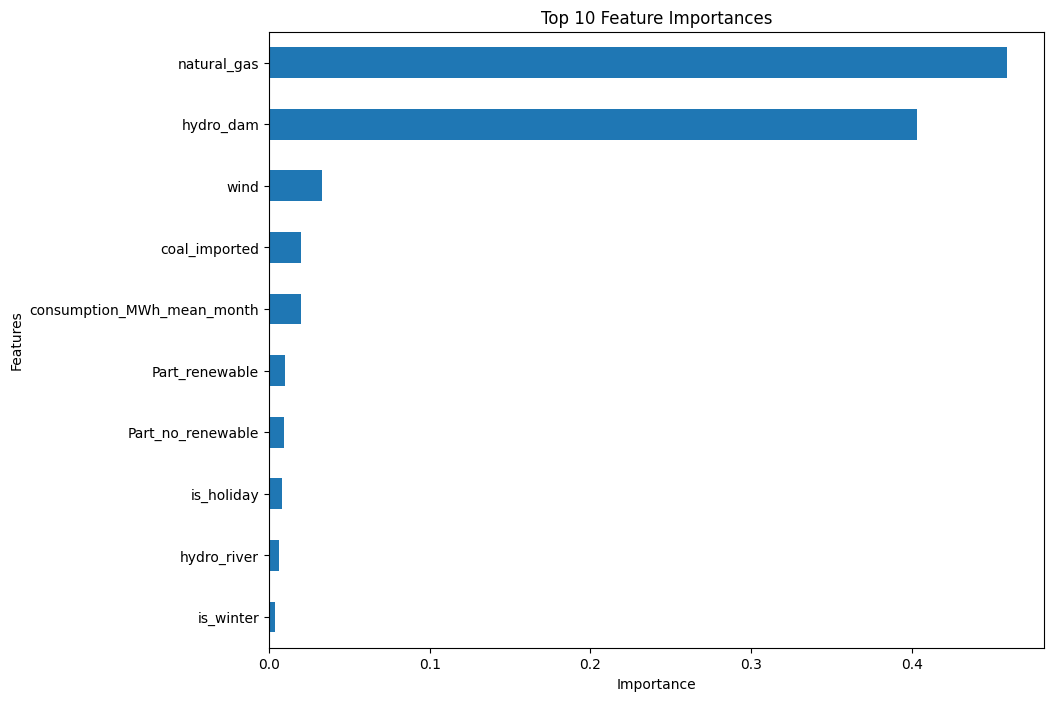

In [ ]:
X = df.drop('consumption_MWh', axis=1)
y = df['consumption_MWh']

# Initialiser et entraîner le RandomForestRegressor sur les 10000 premières observations
model = RandomForestRegressor(random_state=42)
model.fit(X.iloc[:10000], y.iloc[:10000])

# Obtenir l'importance des caractéristiques
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Trier les caractéristiques par importance
sorted_feature_importances = feature_importances.sort_values(ascending=True).tail(10)

# les 10 variables les plus importantes
plt.figure(figsize=(10, 8))
sorted_feature_importances.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Modélisation:

Pour préparer les données, nous procédons à une division séquentielle en ensemble d'entraînement et de test, une méthode essentielle pour conserver la séquentialité des données dans les séries temporelles. Cette approche garantit que l'intégrité temporelle des données est maintenue, permettant ainsi au modèle d'apprendre des tendances et des motifs qui dépendent de l'ordre chronologique des événements. Dans ce cas spécifique, 80% des données sont allouées à l'entraînement et les 20% restants au test. Ensuite, pour chaque sous-ensemble, les variables sont séparées en variables explicatives et variable cible.

In [ ]:
# Créer des indices pour diviser les données :
num_rows = df.shape[0]
train_size = 0.8
idx_train = int(num_rows * train_size)

# Diviser les données en ensembles d'entraînement, de test
train = df.iloc[:idx_train]
test = df.iloc[idx_train:]

# Séparer les variables de caractéristiques et la variable cible :
X_train = train.drop(columns='consumption_MWh')
y_train = train['consumption_MWh']
X_test = test.drop(columns='consumption_MWh')
y_test = test['consumption_MWh']

# Imprimer le nombre d'observations dans chaque ensemble.
print(f"Il y a {train.shape[0]} observations dans l'ensemble d'entraînement.")
print(f"Il y a {test.shape[0]} observations dans l'ensemble de test.")

Il y a 42067 observations dans l'ensemble d'entraînement.
Il y a 10517 observations dans l'ensemble de test.


## Benchmark : modèle naif

Dans cette étape, nous avons implémenté et évalué deux méthodes de prédiction pour établir une ligne de base pour les prédictions futures. Les méthodes utilisées sont la moyenne naïve et la prédiction saisonnière naïve.

- **Moyenne naïve** : Cette méthode calcule la moyenne des dernières 24 heures de la série temporelle de la consommation énergétique dans l'ensemble d'entraînement et utilise cette moyenne constante pour prédire toutes les valeurs de l'ensemble de test. Cette approche est simple et souvent utilisée comme référence pour évaluer si des modèles plus complexes apportent une amélioration significative par rapport à une prédiction très basique.

- **Prédiction saisonnière naïve** : Ici, les dernières valeurs de l'ensemble d'entraînement sont utilisées pour prédire les valeurs correspondantes dans l'ensemble de test, en supposant une saisonnalité ou un cycle répétitif dans les données. Cette méthode est particulièrement adaptée aux données présentant des motifs récurrents sur une période fixe.





Seasonal naive : MAE = 7032.50, RMSE = 8548.35, R2 = -1.18
Naive mean 24 hours : MAE = 4980.97, RMSE = 6078.85, R2 = -0.10


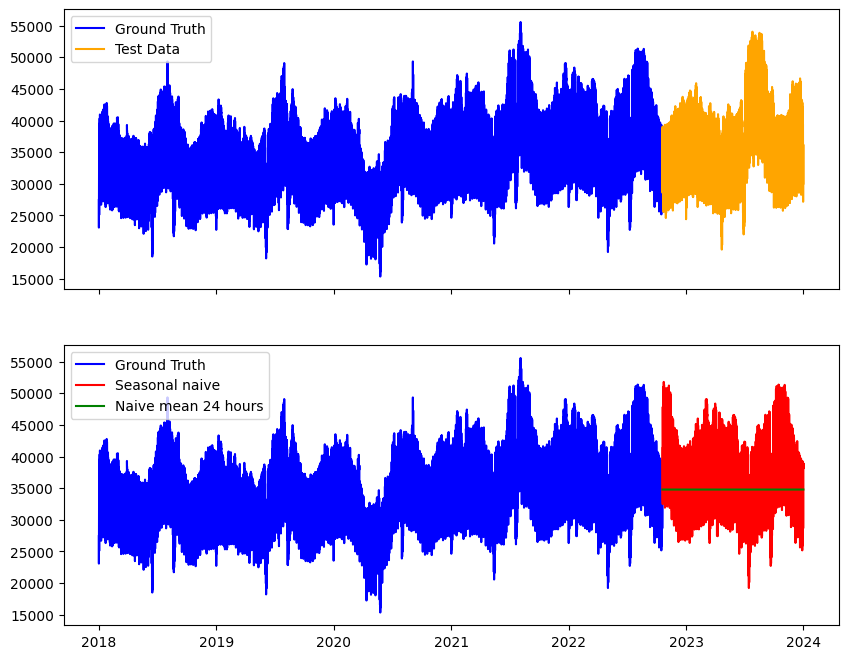

In [ ]:
# Définir les variables :
num_hours = 24  # Nombre d'heures pour la moyenne naïve
num_samples = len(y_test)  # Nombre d'échantillons de test
target_column = 'consumption_MWh'

# Calcul de la moyenne naïve
last_24_hours_mean = np.mean(train[target_column].tail(num_hours))
y_pred_mean = np.full(num_samples, last_24_hours_mean)
mae_mean = mean_absolute_error(y_test, y_pred_mean)
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
r2_mean = r2_score(y_test, y_pred_mean)

# Prédiction saisonnière naïve
y_pred_seas = train[target_column].tail(num_samples).values
mae_seas = mean_absolute_error(y_test, y_pred_seas)
rmse_seas = np.sqrt(mean_squared_error(y_test, y_pred_seas))
r2_seas = r2_score(y_test, y_pred_seas)

# Tracer les courbes de vérité de terrain et les prédictions
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
axes[0].plot(train[target_column], label='Ground Truth', color='blue')
axes[0].plot(test.index, y_test, label='Test Data', color='orange')
axes[0].legend(loc='upper left')
axes[1].plot(train[target_column], label='Ground Truth', color='blue')
axes[1].plot(test.index, y_pred_seas, label='Seasonal naive', color='red')
axes[1].plot(test.index, y_pred_mean, label='Naive mean 24 hours', color='green')
axes[1].legend(loc='upper left')

# Afficher les résultats des modèles de benchmark:
print(f"Seasonal naive : MAE = {mae_seas:.2f}, RMSE = {rmse_seas:.2f}, R2 = {r2_seas:.2f}")
print(f"Naive mean 24 hours : MAE = {mae_mean:.2f}, RMSE = {rmse_mean:.2f}, R2 = {r2_mean:.2f}")

plt.show()

Les prédictions de la méthode saisonnière naïve suivent les contours généraux de la série temporelle réelle mais avec un décalage, ce qui est caractéristique de cette méthode lorsqu'elle rencontre des tendances ou des changements de saisonnalité. En revanche, les prédictions de la moyenne naïve des dernières 24 heures sont représentées par une ligne horizontale, indiquant une prédiction constante basée sur la moyenne récente, sans considération pour les variations saisonnières ou les tendances à long terme.

Les métriques d'erreur indiquent une performance relativement médiocre pour les deux méthodes, avec des valeurs élevées de MAE et RMSE et des valeurs négatives de R2, suggérant que les modèles ne captent pas adéquatement la variabilité des données de test. Un R2 négatif indique que le modèle fait des prédictions pires qu'un modèle très simple qui se contenterait de toujours prédire la moyenne de la variable cible.

Cela implique que, pour améliorer la précision des prédictions dans cette série temporelle, il serait nécessaire de recourir à des modèles plus sophistiqués qui peuvent tenir compte de la saisonnalité complexe, des tendances, et potentiellement d'autres facteurs exogènes influençant la consommation d'énergie. Ces résultats servent de benchmark, montrant qu'il y a beaucoup de place pour l'amélioration par rapport à ces méthodes de prédiction de base.

## Analyse univariée :

Après avoir établi des méthodes de prédiction de base comme références, nous nous orientons vers une analyse univariée. L'analyse univariée se concentre sur la modélisation de la variable cible uniquement en fonction de ses valeurs historiques, sans prendre en compte d'autres variables explicatives potentielles. Dans ce contexte, nous allons exploiter deux modèles statistiques différents : ARMA et Prophet.

- **Le modèle ARMA** (Autoregressive Moving Average) est un outil classique en analyse des séries temporelles qui combine deux composantes : autoregressive (AR) et moving average (MA). La partie AR intègre la dépendance entre une observation et un nombre de lagged (retardées) observations, tandis que la partie MA modélise l'erreur de la prédiction comme une combinaison linéaire des erreurs des prédictions passées.

- **Prophet** est une procédure de prévision pour les données de séries temporelles basée sur un modèle additif où les tendances non linéaires s'ajustent aux saisons annuelles, hebdomadaires et aux effets des vacances. Il est robuste face aux données manquantes et aux changements de tendance, et fonctionne bien avec des séries temporelles qui présentent des effets saisonniers prononcés et plusieurs saisons de données historiques.

L'utilisation de ces deux modèles permet d'aborder la prévision de la consommation d'énergie sous différentes hypothèses et structures de données. ARMA pourrait capturer les dynamiques internes de la série temporelle, tandis que Prophet peut s'ajuster aux changements saisonniers et aux tendances à long terme. La comparaison de leurs performances fournira une compréhension approfondie de la nature temporelle des données et de la meilleure façon de modéliser ces relations pour les prédictions futures.

### Modèle ARMA :

Dans cette étape, nous avons ajusté notre modèle de prédiction en utilisant l'approche ARMA. Nous avons commencé par séparer les données de consommation d'énergie en séries d'entraînement et de test, basées sur l'index calculé précédemment, pour maintenir l'intégrité de la série temporelle.

L'ordre du modèle ARMA a été déterminé comme (2, 0, 2) après l'analyse des corrélogrammes. L'ordre (2, 0, 2) signifie que le modèle comprend deux termes autoregressifs et deux termes de moyenne mobile, sans intégration (d = 0), car la série est considérée comme stationnaire.



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARMA MAE: 4977.99
ARMA RMSE: 6074.17
ARMA R2: -0.10


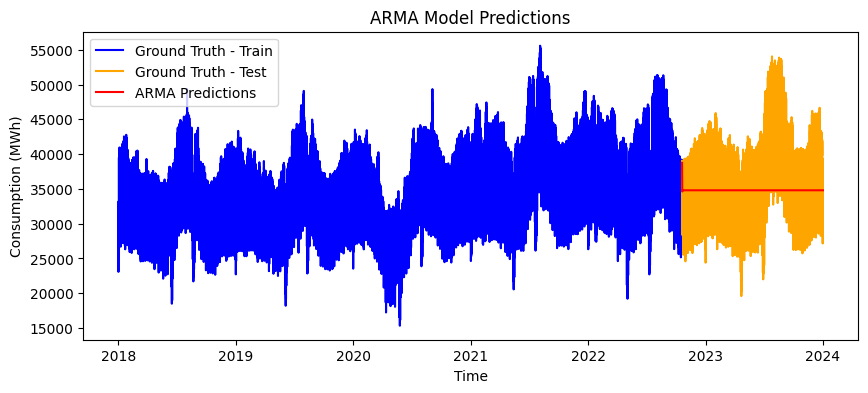

In [ ]:
# Séparation en données d'entraînement et de test
train_series = df['consumption_MWh'][:idx_train]
test_series = df['consumption_MWh'][idx_train:]

# Entraînement du modèle ARMA :
# Nous avons choisit l'ordre (p, d, q) en fonction des corrélogrammes:
arma_order = (2, 0, 2)
model = ARIMA(train_series, order=arma_order)
model_fit = model.fit()

# Prédiction
y_pred_arma = model_fit.predict(start=len(train_series), end=len(train_series) + len(test_series) - 1)

# Calcul de la MAE pour ARMA
mae_arma = mean_absolute_error(test_series, y_pred_arma)
# Calcul de la RMSE pour ARMA
rmse_arma = np.sqrt(mean_squared_error(test_series, y_pred_arma))
# Calcul de la R2 pour ARMA
r2_arma = r2_score(test_series, y_pred_arma)

print(f'ARMA MAE: {mae_arma:.2f}')
print(f'ARMA RMSE: {rmse_arma:.2f}')
print(f'ARMA R2: {r2_arma:.2f}')

plt.figure(figsize=(10, 4))

# Tracer les données réelles de l'ensemble d'entraînement
plt.plot(df.index[:idx_train], train_series, color='blue', label='Ground Truth - Train')

# Tracer les données réelles de l'ensemble de test
plt.plot(df.index[idx_train:], test_series, color='orange', label='Ground Truth - Test')

# Tracer les prédictions de ARMA pour l'ensemble de test
plt.plot(df.index[idx_train:], y_pred_arma, color='red', label='ARMA Predictions')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Consumption (MWh)')
plt.title('ARMA Model Predictions')
plt.show()

Les prédictions d'ARMA semblent se situer en moyenne autour d'une certaine valeur, indiquée par la ligne rouge horizontale.
Le MAE et le RMSE sont relativement élevés, ce qui indique une précision de prédiction médiocre. Un R2 négatif suggère que le modèle ARMA ne parvient pas à capturer la variance de la série temporelle et est inférieur en performance à un modèle simple de prédiction de la moyenne.

À partir de ce graphique, il est évident que les prédictions d'ARMA ne correspondent pas aux fluctuations réelles observées dans les données d'entraînement ou de test. Le modèle semble ne pas être capable de saisir la volatilité ou les tendances saisonnières des données, ce qui est critique pour la prévision de la consommation énergétique. Cela suggère que le modèle ARMA, dans sa configuration actuelle, n'est pas adéquat pour cette tâche spécifique.

### Modèle Prophet :

Tout d'abord, le DataFrame a été préparé pour l'utilisation avec Prophet : l'index du temps a été réinitialisé et les colonnes ont été renommées conformément aux attentes de Prophet, avec le temps renommé en 'ds' et la variable cible en 'y'.

Nous avons ensuite séparé les données en ensembles d'entraînement et de test en utilisant l'index prédéfini. Le modèle Prophet a été instancié et entraîné sur l'ensemble d'entraînement.

In [ ]:
df_prophet = df.reset_index().rename(columns={'time': 'ds', 'consumption_MWh': 'y'})

# Séparation en données d'entraînement et de test
train_data = df_prophet.iloc[:idx_train]
test_data = df_prophet.iloc[idx_train:]

# Entraînement du modèle Prophet
model = Prophet()
model.fit(train_data)

# Préparation pour la prédiction
future = model.make_future_dataframe(periods=len(test_data), freq='H')
forecast = model.predict(future)

MAE: 2152.511277646955
RMSE: 2912.6971651163008
R2: 0.7466396187073066


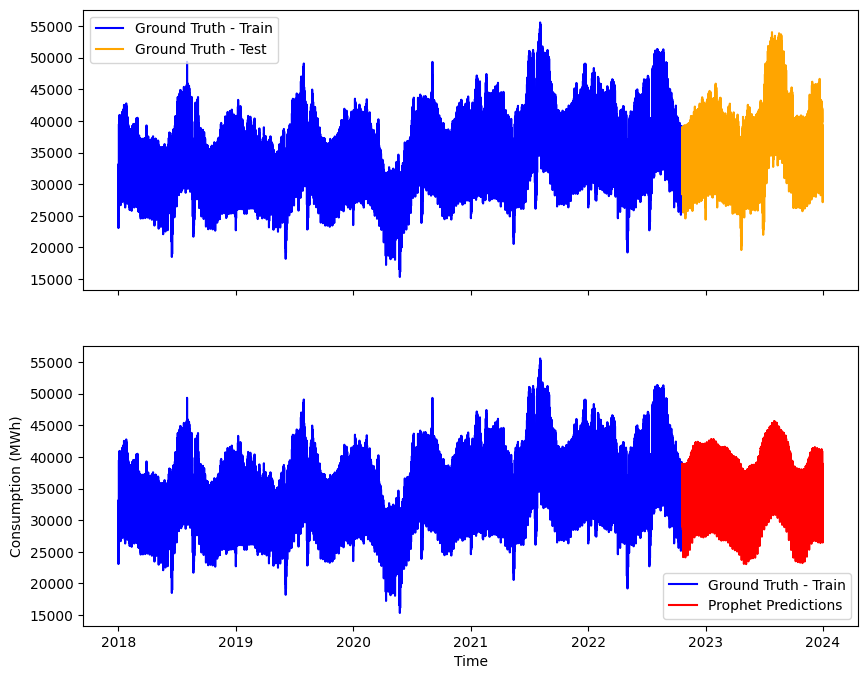

In [ ]:
# En utilisant les prédictions de Prophet
y_pred_prophet = forecast['yhat'][idx_train:]

# Données réelles de l'ensemble de test pour comparer
actual_values = test_data['y']

# Calcul de la MAE pour Prophet
mae_prophet = mean_absolute_error(actual_values, y_pred_prophet)
# Calcul de la RMSE pour Prophet
rmse_prophet = np.sqrt(mean_squared_error(actual_values, y_pred_prophet))
# Calcul de la R2 pour Prophet
r2_prophet = r2_score(actual_values, y_pred_prophet)

print(f"MAE: {mae_prophet}")
print(f"RMSE: {rmse_prophet}")
print(f"R2: {r2_prophet}")

# Récupération du nom de la colonne cible
TARGET = 'y'

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Tracer les données réelles de l'ensemble d'entraînement
axes[0].plot(train_data['ds'], train_data[TARGET], color='blue', label='Ground Truth - Train')
# Tracer les données réelles de l'ensemble de test
axes[0].plot(test_data['ds'], test_data[TARGET], color='orange', label='Ground Truth - Test')
axes[0].legend()

# Tracer les données réelles de l'ensemble d'entraînement
axes[1].plot(train_data['ds'], train_data[TARGET], color='blue', label='Ground Truth - Train')
# Tracer les prédictions de Prophet pour l'ensemble de test
axes[1].plot(test_data['ds'], y_pred_prophet, color='red', label='Prophet Predictions')
axes[1].legend()

plt.xlabel('Time')
plt.ylabel('Consumption (MWh)')

plt.show()

Les métriques de performance indiquent une MAE d'environ 2152, une RMSE d'environ 2912, et un R2 d'environ 0.75. Ces valeurs suggèrent que, bien que le modèle Prophet ne soit pas parfait, il fournit une prédiction raisonnablement précise de la consommation d'énergie. En particulier, un R2 de 0.75 signifie que le modèle peut expliquer environ 75% de la variabilité dans les données de test, ce qui est un bon résultat pour les données de séries temporelles souvent sujettes à des variations inattendues.

En regardant les graphiques, on peut voir que le modèle capture les tendances générales de la consommation d'énergie et semble suivre l'évolution saisonnière, comme en témoigne la fluctuation des prédictions par rapport aux données de test. Cependant, il y a des zones où les prédictions ne correspondent pas exactement aux pics et aux creux réels, ce qui est courant avec les modèles de prévision qui visent à capturer la tendance générale plutôt que les fluctuations à court terme.

Globalement, le modèle Prophet semble offrir une amélioration substantielle par rapport aux méthodes de base et se présente comme un outil de prévision valable.

## Analyse multivariée :

Après avoir réalisé une analyse univariée pour comprendre comment la variable cible peut être prédite à partir de ses propres valeurs historiques, nous élargissons notre perspective en intégrant une analyse multivariée. Cette approche plus complexe tient compte non seulement des valeurs passées de la consommation d'énergie mais aussi de l'influence potentielle d'autres variables exogènes. L'analyse multivariée permet de capter les dynamiques et les interdépendances entre la variable cible et les variables exogènes, ce qui pourrait améliorer la précision des prédictions.

Pour cette analyse multivariée, nous exploitons la puissance de deux modèles avancés:

- **LSTM (Long Short-Term Memory)** : un type spécialisé de réseaux de neurones récurrents, qui est particulièrement adapté pour apprendre des ordres de dépendance à long terme. Les LSTM sont conçus pour éviter le problème de disparition du gradient, rendant ces modèles appropriés pour apprendre des séquences de données avec des dépendances complexes et de longue durée, typiques dans les séries temporelles multivariées. Dans notre cas, un LSTM peut être utilisé pour capturer la dynamique temporelle des variables exogènes en relation avec la consommation d'énergie.

- **LGBM (Light Gradient Boosting Machine)** : un modèle de boosting de gradient qui construit l'apprentissage en séquences de modèles faibles, souvent des arbres de décision, de manière à ce que chaque modèle subséquent corrige les erreurs du précédent. LGBM est réputé pour sa vitesse et son efficacité, surtout sur de grandes quantités de données et dans des scénarios où la dimensionnalité est élevée. Son application aux données multivariées peut révéler des interactions non linéaires et des hiérarchies entre les variables exogènes et la consommation d'énergie.

En utilisant LSTM et LGBM, nous allons développer des modèles qui non seulement prévoient la consommation en se basant sur son historique mais également en considérant l'influence des autres facteurs mesurables au cours du temps. Cela devrait fournir une compréhension plus riche et des prédictions plus robustes, en tenant compte de la complexité et de la multidimensionnalité du problème.

### Modèle LSTM :

Dans cette étape, nous avons préparé les données pour l'entraînement et le test du modèle LSTM. Nous avons introduit un décalage (lag) de 5, ce qui signifie que chaque entrée de modèle (feature) sera une séquence de 5 observations passées consécutives.

Nous avons commencé par créer des séquences d'entrée pour le modèle à partir des données d'entraînement. Pour chaque point de donnée que nous voulons prédire, nous avons pris les 5 mesures précédentes comme une séquence pour former les features. La variable à prédire correspond à la valeur immédiatement après chaque séquence.

Ces séquences ont ensuite été transformées en tableaux numpy, qui sont compatibles avec les exigences d'entrée du modèle LSTM. Cette transformation est essentielle car les LSTMs nécessitent une entrée tridimensionnelle sous la forme de (échantillons, pas de temps, caractéristiques).

Ensuite, nous avons préparé de manière similaire les données de test en veillant à commencer la séquence en tenant compte du décalage pour que les prédictions soient alignées correctement avec les vraies valeurs.

Enfin, nous avons mis à l'échelle les données à l'aide de MinMaxScaler pour redimensionner les données d'entrée (features) et de sortie (targets) dans un intervalle de 0 à 1.



In [ ]:
# Créer des indices pour diviser les données :
num_rows = df.shape[0]
train_size = 0.8
idx_train = int(num_rows * train_size)

In [ ]:
lag = 5

# Préparation des données d'entraînement pour le modèle LSTM
train_data = df.iloc[:idx_train]

x_train = []
y_train = []

# Boucle pour créer des séquences de la longueur spécifiée par 'lag'
for i in range(lag, idx_train):
    x_train.append(train_data.iloc[i-lag:i].values)
    y_train.append(train_data.iloc[i, 0])

# Convertir les listes en numpy arrays :
x_train, y_train = np.array(x_train), np.array(y_train)

# Vérifier les formes pour s'assurer que les dimensions sont correctes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Préparation des données de test pour le modèle LSTM:
test_data = df.iloc[idx_train - lag:]  # Commencer à partir de 'idx_train - lag' pour avoir assez de données pour créer la première séquence

x_test = []
y_test = []

# Boucle pour créer des séquences de la longueur spécifiée par 'lag'
for i in range(lag, len(test_data)):
    x_test.append(test_data.iloc[i-lag:i].values)
    y_test.append(test_data.iloc[i, 0])

# Convertir les listes en numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Vérifier les formes pour s'assurer que les dimensions sont correctes
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (42062, 5, 28)
y_train shape: (42062,)
x_test shape: (10517, 5, 28)
y_test shape: (10517,)


In [ ]:

# Créer un scaler pour les données d'entrée
scaler_x = MinMaxScaler()

x_train_reshaped = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
x_test_reshaped = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])

# Appliquer MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

# Remodeler les données mises à l'échelle pour les ramener à la forme originale
x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

# Créer un scaler pour les données cibles
scaler_y = MinMaxScaler()

# Adapter le scaler aux données cibles et transformer les données cibles
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1,)

Dans cette étape, nous avons construit et entraîné le modèle.

- Construction du modèle LSTM : Nous avons initialisé un modèle séquentiel. Le modèle est composé de deux couches LSTM, qui sont conçues pour capturer les dépendances temporelles à différents niveaux de complexité et de généralisation. La première couche LSTM a une taille d'unité de 32 et renvoie des séquences complètes pour être traitées par la couche suivante qui ne renvoie que le dernier output pour transitionner vers une couche dense.

- Régularisation Dropout : Nous avons ajouté une couche de dropout (degré 0.1). Le dropout est une forme de régularisation qui aide à prévenir le surajustement en désactivant aléatoirement un pourcentage des unités pendant l'entraînement, ce qui force le réseau à apprendre des représentations plus robustes des données.

- Couche de sortie : Nous avons ajouté une couche dense avec une seule unité à la fin du réseau, car nous réalisons une tâche de régression.

- Compilation du modèle : Le modèle a été compilé avec l'optimiseur Adam, une fonction de perte basée sur l'erreur quadratique moyenne, et la métrique de performance étant l'erreur absolue moyenne. Adam est un choix populaire pour l'entraînement de réseaux de neurones en raison de sa capacité à ajuster le taux d'apprentissage pendant l'entraînement, et MSE est une fonction de perte standard pour les problèmes de régression.

- Callbacks : Pour l'entraînement, nous avons utilisé deux callbacks : `EarlyStopping` pour interrompre l'entraînement si la perte de validation ne s'améliore pas après un certain nombre d'époques, et `ReduceLROnPlateau` pour réduire le taux d'apprentissage si la perte de validation cesse de s'améliorer. Ces callbacks sont des outils puissants pour éviter le surajustement et pour optimiser le processus d'entraînement.

- Entraînement du modèle : Enfin, nous avons entraîné le modèle en utilisant les données d'entraînement avec validation sur les données de test. L'entraînement utilise des données de validation pour ajuster les hyperparamètres et surveiller la performance, avec un batch size de 32 et pour un maximum de 100 époques.

In [ ]:
# Construire le modèle
model = Sequential()

model.add(LSTM(units=32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh', return_sequences=True))

model.add(LSTM(units = 16, activation = 'tanh', return_sequences = False))

model.add(Dropout(0.1))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Résumé du modèle pour vérifier l'architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             7808      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10961 (42.82 KB)
Trainable params: 10961 (42.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Configuration des callbacks pour une meilleure gestion de l'entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Entraîner le modèle avec les données mises à l'échelle
model.fit(x_train_scaled, y_train_scaled, validation_data=(x_test_scaled, y_test_scaled), batch_size=32, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1315/1315 [==============================] - 25s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0485 - val_loss: 0.0013 - val_mean_absolute_error: 0.0273 - lr: 0.0010
Epoch 2/100
1315/1315 [==============================] - 12s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - val_loss: 7.6468e-04 - val_mean_absolute_error: 0.0213 - lr: 0.0010
Epoch 3/100
1315/1315 [==============================] - 12s 9ms/step - loss: 8.7883e-04 - mean_absolute_error: 0.0224 - val_loss: 4.7090e-04 - val_mean_absolute_error: 0.0163 - lr: 0.0010
Epoch 4/100
1315/1315 [==============================] - 12s 9ms/step - loss: 5.8442e-04 - mean_absolute_error: 0.0183 - val_loss: 4.8856e-04 - val_mean_absolute_error: 0.0174 - lr: 0.0010
Epoch 5/100
1315/1315 [==============================] - 12s 9ms/step - loss: 4.7482e-04 - mean_absolute_error: 0.0166 - val_loss: 3.8640e-04 - val_mean_absolute_error: 0.0148 - lr: 0.0010
Epoch 6/100
1315/1315 [==============================] - 12s 9ms/s

329/329 [==============================] - 2s 6ms/step
MAE: 408.9087334494153
RMSE: 544.2917729448384
R2: 0.9911526832190994


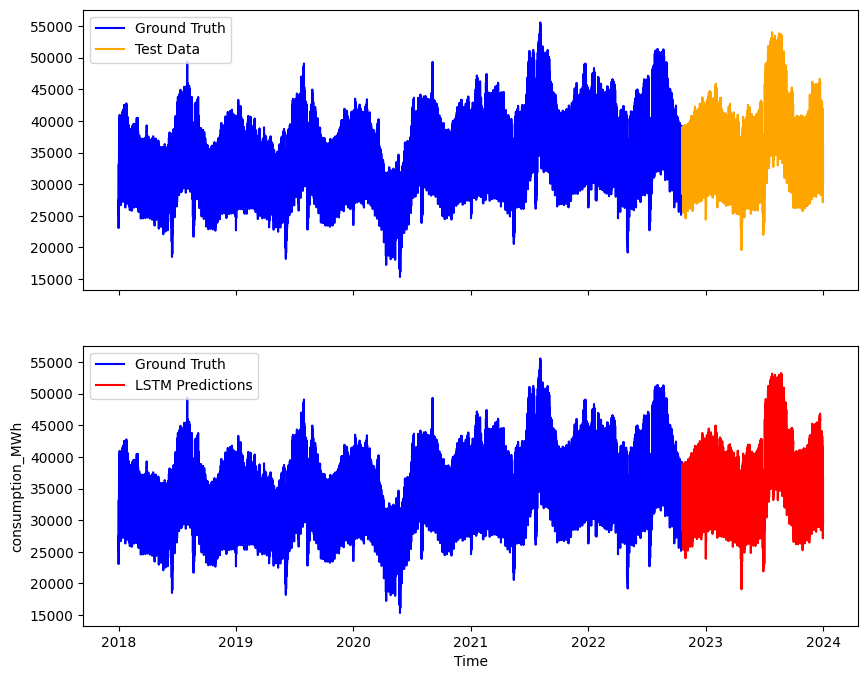

In [ ]:
# Prédire les valeurs pour les données de test
y_pred_scaled = model.predict(x_test_scaled)

# Remettre à l'échelle les prédictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Prédiction avec le modèle LSTM
y_pred_lstm = y_pred
# Données réelles de l'ensemble de test pour comparer
actual_values = y_test

# Calcul de la MAE pour LSTM
mae_lstm = mean_absolute_error(actual_values, y_pred_lstm)
# Calcul de la RMSE pour LSTM
rmse_lstm = np.sqrt(mean_squared_error(actual_values, y_pred_lstm))
# Calcul de la R2 pour LSTM
r2_lstm = r2_score(actual_values, y_pred_lstm)

print(f"MAE: {mae_lstm}")
print(f"RMSE: {rmse_lstm}")
print(f"R2: {r2_lstm}")

TARGET = 'consumption_MWh'

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Tracer les données réelles sur les deux subplots pour la comparaison
axes[0].plot(train.index, train[TARGET], color='blue', label='Ground Truth')
axes[0].plot(test.index, y_test, color='orange', label='Test Data')
axes[0].legend()

# Tracer les données réelles et les prédictions du LSTM sur le deuxième subplot
axes[1].plot(train.index, train[TARGET], color='blue', label='Ground Truth')
axes[1].plot(test.index, y_pred_lstm, color='red', label='LSTM Predictions')

axes[1].legend()

plt.xlabel('Time')
plt.ylabel(TARGET)

plt.show()

Les métriques sont significatives, ce qui implique normalement une précision modérée dans les prédictions. Cependant, ces métriques peuvent parfois exagérer l'impact des erreurs dues à des valeurs aberrantes ou des pics imprévisibles dans les données de test. Le R2 est extrêmement élevé, suggérant que, malgré les erreurs absolues, le modèle est capable de capturer une grande partie de la variance des données.

Visuellement, les prédictions LSTM semblent suivre étroitement les fluctuations réelles observées dans l'ensemble de test. La capacité du modèle à prédire la consommation dans la période de test avec une certaine précision est encourageante. Cela suggère qu'avec une optimisation plus poussée et peut-être une formation supplémentaire ou l'intégration d'autres variables pertinentes, le modèle pourrait être amené à une performance encore meilleure.



### Modèle LGBM :

Comme LightGBM nécessite des données d'entrée en deux dimensions, nous avons commencé par remodeler les données d'entraînement et de test. Le remodelage a transformé les données pour chaque séquence en un vecteur unidimensionnel, permettant ainsi au modèle LightGBM de traiter les données qui étaient initialement formatées pour un modèle LSTM.

Après avoir redimensionné les données, nous avons initialisé le modèle LightGBMRegressor et l'avons entraîné sur l'ensemble d'entraînement.

In [ ]:
# Reshaper la  data
x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

#  LGBM model
model = LGBMRegressor()

model.fit(x_train_reshaped, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19010
[LightGBM] [Info] Number of data points in the train set: 42062, number of used features: 140
[LightGBM] [Info] Start training from score 34799.254442


LGBMRegressor()

MAE: 334.53
RMSE: 466.68
R2: 0.99


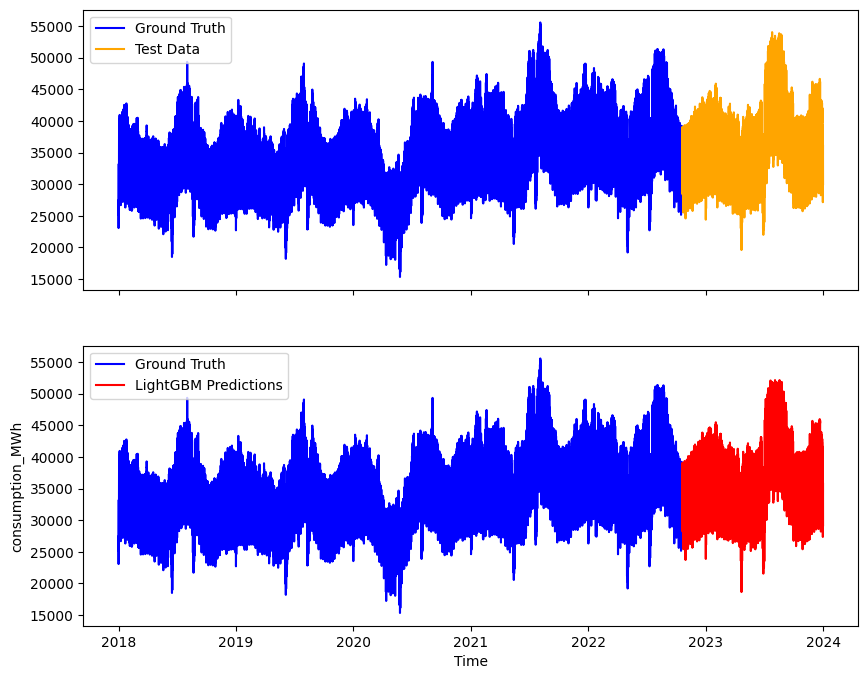

In [ ]:
# Predictions
y_pred = model.predict(x_test_reshaped)

# Données réelles de l'ensemble de test pour comparer
actual_values = y_test

# Evaluer le modele
mae = mean_absolute_error(actual_values, y_pred)
rmse = np.sqrt(mean_squared_error(actual_values, y_pred))
r2 = r2_score(actual_values, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

TARGET = 'consumption_MWh'

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(train.index, train[TARGET], color='blue', label='Ground Truth')
axes[0].plot(test.index, y_test, color='orange', label='Test Data')
axes[0].legend()

axes[1].plot(train.index, train[TARGET], color='blue', label='Ground Truth')
axes[1].plot(test.index, y_pred, color='red', label='LightGBM Predictions')

axes[1].legend()

plt.xlabel('Time')
plt.ylabel(TARGET)

plt.show()

Les métriques indiquent une performance impressionnante, avec un MAE relativement faible et un RMSE modéré, tandis que le R2 est presque parfait, suggérant que le modèle prévoit la variation dans les données de test avec une grande précision.

Visuellement, les prédictions du LightGBM semblent épouser la forme générale des données réelles, capturant efficacement les tendances et fluctuations saisonnières. Bien que certaines disparités puissent exister entre les valeurs prédites et les valeurs réelles, notamment dans la capture des pics les plus extrêmes, l'alignement général est très prometteur. Cela suggère que le modèle LightGBM a non seulement appris les motifs généraux des données historiques mais est également capable de les appliquer pour faire des prédictions compétentes.

# Comparaison et discussion des performances :

| Modèle              |    MAE    |    RMSE    |    R2    |
|---------------------|-----------|------------|----------|
| Seasonal naive      |  7032.50  |  8548.35   |  -1.18   |
| Naive mean 24 hours |  4980.97  |  6078.85   |  -0.10   |
| Modèle ARMA         |  4977.99  |  6074.17   |  -0.10   |
| Prophet             |  2152.51  |  2912.70   |   0.75   |
| LSTM                | 408.90 | 544.29   | 0.99|
| LightGBM            |  334.53   |   466.68   |   0.99   |

Ce tableau résume les performances de différents modèles, évalués selon les métriques MAE, RMSE et R2.

Les modèles de base, Seasonal naive et Naive mean 24 hours, ont montré des performances relativement médiocres avec des MAE et RMSE élevés et des valeurs négatives de R2, ce qui indique que ces modèles ne sont pas adéquats pour capturer la complexité des données. Ces approches simplistes peuvent servir de lignes de base pour la comparaison, mais elles ne sont généralement pas suffisantes pour des prédictions précises, car elles ne tiennent pas compte des tendances, de la saisonnalité ni d'autres facteurs influençant la série temporelle.

Le modèle ARMA, une méthode classique en analyse des séries temporelles, a légèrement amélioré les performances par rapport aux modèles naïfs, mais a toujours un R2 négatif, indiquant qu'il ne s'ajuste pas bien aux données non stationnaires ou aux séries avec des dynamiques complexes.

Prophet est un modèle robuste pour les données avec des tendances non linéaires et une forte saisonnalité, et son meilleur score de R2 parmi les méthodes initiales montre sa capacité à modéliser la série temporelle de manière plus efficace. Avec un MAE et un RMSE bien plus faibles que les modèles précédents, Prophet se révèle être un choix solide pour les données de consommation d'énergie qui peuvent présenter des schémas saisonniers distincts et des événements de vacances influents.

Les modèles LSTM et LightGBM offrent des performances exceptionnelles, avec des valeurs de R2 frôlant la perfection et les plus faibles erreurs MAE et RMSE. Cela indique une excellente capacité à prédire précisément la consommation d'énergie tout en capturant la complexité sous-jacente des séries temporelles. Les LSTM sont particulièrement adaptés pour apprendre des séquences de données grâce à leur mémoire interne, ce qui leur permet de capter des dépendances à long terme dans les données. LightGBM, d'autre part, utilise un gradient boosting efficace et est capable de gérer des ensembles de données de grande dimension, ce qui est souvent le cas avec des séries temporelles multivariées.

En conclusion, bien que Prophet soit un choix robuste et accessible pour de nombreuses applications de séries temporelles, les LSTM et LightGBM offrent des niveaux de précision nettement supérieurs dans ce cas particulier, démontrant leur puissance et leur flexibilité pour des tâches prédictives complexes. Leur capacité à modéliser avec précision des séquences temporelles complexes et non linéaires les rend particulièrement adaptés aux défis posés par les données de consommation d'énergie, qui sont souvent affectées par des facteurs saisonniers, des tendances à long terme, et des relations non linéaires entre les variables.

# Conclusion :

La synthèse des performances des divers modèles de prédiction sur les données de consommation d'énergie met en évidence une progression notable depuis les approches de base jusqu'aux techniques de modélisation avancées. Tandis que les méthodes saisonnière naïve et moyenne sur 24 heures servent de benchmarks rudimentaires, les modèles ARMA et Prophet marquent un pas significatif vers la prise en compte de la complexité inhérente aux séries temporelles. Prophet, avec sa capacité à intégrer des composantes saisonnières et de tendance, démontre une compétence modérée dans la modélisation de telles données. Cependant, c'est avec les modèles LSTM et LightGBM que nous observons une capacité prédictive supérieure, illustrée par des scores de précision élevés, indiquant une compréhension approfondie des dynamiques de séries temporelles.

En conclusion, la modélisation de la consommation d'énergie, riche en patterns et influences variées, bénéficie grandement des méthodes de machine learning sophistiquées. Les LSTM, avec leur architecture spécialisée pour les données séquentielles, et LightGBM, grâce à son approche efficace du gradient boosting, émergent comme des outils prédictifs de premier plan.

Pour l'amélioration future, il serait judicieux d'explorer l'intégration de variables exogènes, telles que les conditions météorologiques ou les données économiques, qui pourraient affiner la précision des modèles. De plus, une exploration plus approfondie des hyperparamètres et une analyse des erreurs peuvent aider à cerner et à corriger les faiblesses spécifiques des modèles. Enfin, l'adoption de techniques d'ensemble, combinant les forces de différents modèles, pourrait offrir une robustesse et une précision accrues pour répondre aux exigences des applications pratiques en matière de prévision énergétique.

**NB** : Bien que les résultats obtenus avec les modèles LSTM et LightGBM soient prometteurs, nous n'avons pas encore exploité pleinement leur potentiel en raison de contraintes liées à leur complexité et aux ressources disponibles. L'optimisation des hyperparamètres, telle que l'optimisation bayésienne ou les méthodes de recherche exhaustive, est en effet un élément essentiel de la modélisation des séries temporelles pour affiner la performance des modèles. Ces techniques d'optimisation sont particulièrement puissantes car elles permettent de naviguer systématiquement dans l'espace des hyperparamètres pour trouver la configuration optimale qui améliore la précision des prédictions.

La multidimensionnalité des données et l'architecture complexe des modèles, tels que le nombre de couches ou la taille des unités dans les LSTM et le taux d'apprentissage ou le nombre d'itérations dans LightGBM, ajoutent des couches de complexité à l'optimisation. Ces aspects, combinés à des ressources de calcul limitées, peuvent rendre la recherche de la meilleure configuration très exigeante en temps et en puissance de calcul.